# Develop a “Tell-the-time” network.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from functools import partial
from keras.optimizers import Adam
from matplotlib import pyplot as plt

In [8]:
'''
Load the dataset and normalize the images
'''

images = np.load("/kaggle/input/clock-dataset/images.npy") / 255
labels = np.load("/kaggle/input/clock-dataset/labels.npy")

In [9]:
print(images.shape)
print(labels.shape)


# 24 Categories
# categories = (labels[:, 0] * 2 + labels[:, 1] // 30) % 24

# 720 Categories
# categories = (labels[:, 0] * 60 + labels[:, 1]) % 720

# 144 categories
categories = (labels[:, 0] * 12 + labels[:, 1] // 5) % 144



categories = categories.reshape(-1, 1)
print(categories.shape)

# Number of categories
num_categories = np.unique(categories)
print("Number of classes:", len(num_categories))

# Process categories into one-hot encoded labels
labels = to_categorical(categories, num_classes=144)
print(labels.shape)

(18000, 150, 150)
(18000, 2)
(18000, 1)
Number of classes: 144
(18000, 144)


In [10]:
'''
Prepare the train / validation / test data from dataset
'''

X_train, X_var, y_train, y_var = train_test_split(images, labels, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_var, y_var, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(10800, 150, 150)
(3600, 150, 150)
(3600, 150, 150)


In [7]:
'''
Data augmentation logic for training classifier on 720 labels
'''

# X_train = X_train.reshape(-1, 150, 150, 1)
print(X_train.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

datagen.fit(X_train)

(10800, 150, 150, 1)


In [22]:
'''
CNN network for 24-class classification problem
'''

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=4, activation='leaky_relu', padding='same')


# 24 Categories
model = keras.Sequential([
    DefaultConv2D(filters=16, kernel_size=7, input_shape=[150, 150, 1], kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=32),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=64),
    layers.MaxPooling2D(pool_size=4),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units=256, activation='leaky_relu'),
    layers.Dense(units=512, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(units=24, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [23]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                                 validation_data=(X_valid, y_valid))

Epoch 1/50


2023-10-26 13:50:51.617376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


338/338 [==============================] - 9s 14ms/step - loss: 3.1825 - accuracy: 0.0413 - val_loss: 3.1799 - val_accuracy: 0.0425
Epoch 2/50
338/338 [==============================] - 4s 11ms/step - loss: 3.1795 - accuracy: 0.0397 - val_loss: 3.1774 - val_accuracy: 0.0347
Epoch 3/50
338/338 [==============================] - 4s 11ms/step - loss: 3.0510 - accuracy: 0.0681 - val_loss: 2.7051 - val_accuracy: 0.1192
Epoch 4/50
338/338 [==============================] - 4s 11ms/step - loss: 2.5097 - accuracy: 0.1695 - val_loss: 2.1301 - val_accuracy: 0.2689
Epoch 5/50
338/338 [==============================] - 4s 11ms/step - loss: 2.0013 - accuracy: 0.2940 - val_loss: 1.6593 - val_accuracy: 0.3897
Epoch 6/50
338/338 [==============================] - 4s 11ms/step - loss: 1.6309 - accuracy: 0.4133 - val_loss: 1.3483 - val_accuracy: 0.5072
Epoch 7/50
338/338 [==============================] - 4s 11ms/step - loss: 1.4063 - accuracy: 0.4831 - val_loss: 1.1565 - val_accuracy: 0.5733
Epoch 8/50

In [25]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'24-class model test accuracy: {test_accuracy}')

113/113 [==============================] - 1s 5ms/step - loss: 0.3368 - accuracy: 0.8872
24-class model test accuracy: 0.8872222304344177


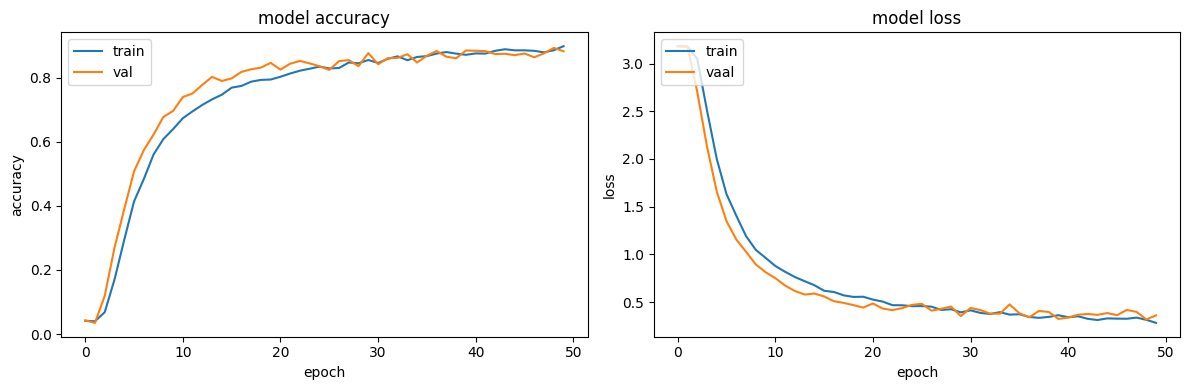

In [26]:
'''
Plot the performance related details from 24-class model
'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'vaal'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
'''
CNN network for 720-class classification problem
'''

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=4, activation='leaky_relu', padding='same')

# 720 Categories
model = keras.Sequential([
    DefaultConv2D(filters=16, kernel_size=7, input_shape=[150, 150, 1], kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=32),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=64),
    layers.MaxPooling2D(pool_size=4),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units=256, activation='leaky_relu'),
    layers.Dense(units=512, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(units=720, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 37, 37, 32)        8224      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 64)        

In [34]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=5), epochs=200, batch_size=32,
                                 validation_data=(X_valid, y_valid))

Epoch 1/200
2160/2160 [==============================] - 25s 11ms/step - loss: 4.4143 - accuracy: 0.0619 - val_loss: 4.3775 - val_accuracy: 0.0606
Epoch 2/200
2160/2160 [==============================] - 24s 11ms/step - loss: 4.3542 - accuracy: 0.0662 - val_loss: 4.5569 - val_accuracy: 0.0433
Epoch 3/200
2160/2160 [==============================] - 24s 11ms/step - loss: 4.2880 - accuracy: 0.0678 - val_loss: 4.5919 - val_accuracy: 0.0464
Epoch 4/200
2160/2160 [==============================] - 24s 11ms/step - loss: 4.2517 - accuracy: 0.0700 - val_loss: 4.2792 - val_accuracy: 0.0561
Epoch 5/200
2160/2160 [==============================] - 24s 11ms/step - loss: 4.2125 - accuracy: 0.0726 - val_loss: 4.6170 - val_accuracy: 0.0492
Epoch 6/200
2160/2160 [==============================] - 24s 11ms/step - loss: 4.1559 - accuracy: 0.0699 - val_loss: 4.5159 - val_accuracy: 0.0486
Epoch 7/200
2160/2160 [==============================] - 24s 11ms/step - loss: 4.0907 - accuracy: 0.0802 - val_loss: 4

In [8]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'720-class model test accuracy: {test_accuracy}')

113/113 [==============================] - 6s 5ms/step - loss: 2.4448 - accuracy: 0.3644
720-class model test accuracy: 0.36444443464279175


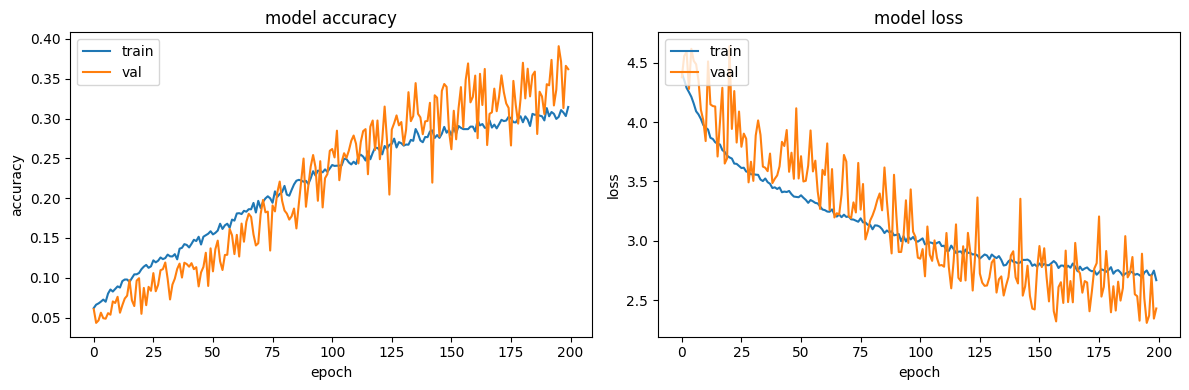

In [14]:
'''
Plot the performance related details from 720-class model
'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'vaal'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
'''
CNN network for 144-class classification problem
'''

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=4, activation='leaky_relu', padding='same')


# 144 Categories
model = keras.Sequential([
    DefaultConv2D(filters=16, kernel_size=7, input_shape=[150, 150, 1], kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=32),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=64),
    layers.MaxPooling2D(pool_size=4),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units=256, activation='leaky_relu'),
    layers.Dense(units=512, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(units=144, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 32)        8224      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 64)        

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                                 validation_data=(X_valid, y_valid))

Epoch 1/50


2023-11-01 12:41:35.784987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


338/338 [==============================] - 14s 14ms/step - loss: 4.9756 - accuracy: 0.0064 - val_loss: 4.9718 - val_accuracy: 0.0061
Epoch 2/50
338/338 [==============================] - 4s 11ms/step - loss: 4.9719 - accuracy: 0.0055 - val_loss: 4.9733 - val_accuracy: 0.0064
Epoch 3/50
338/338 [==============================] - 4s 11ms/step - loss: 4.9714 - accuracy: 0.0060 - val_loss: 4.9737 - val_accuracy: 0.0044
Epoch 4/50
338/338 [==============================] - 4s 11ms/step - loss: 4.9706 - accuracy: 0.0068 - val_loss: 4.9751 - val_accuracy: 0.0064
Epoch 5/50
338/338 [==============================] - 4s 11ms/step - loss: 4.9688 - accuracy: 0.0080 - val_loss: 4.9449 - val_accuracy: 0.0078
Epoch 6/50
338/338 [==============================] - 4s 11ms/step - loss: 4.4780 - accuracy: 0.0312 - val_loss: 3.5298 - val_accuracy: 0.0964
Epoch 7/50
338/338 [==============================] - 4s 11ms/step - loss: 3.2349 - accuracy: 0.1188 - val_loss: 2.6005 - val_accuracy: 0.2222
Epoch 8/5

In [13]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'144-class model test accuracy: {test_accuracy}')

113/113 [==============================] - 1s 5ms/step - loss: 0.8363 - accuracy: 0.7294
144-class model test accuracy: 0.7294444441795349


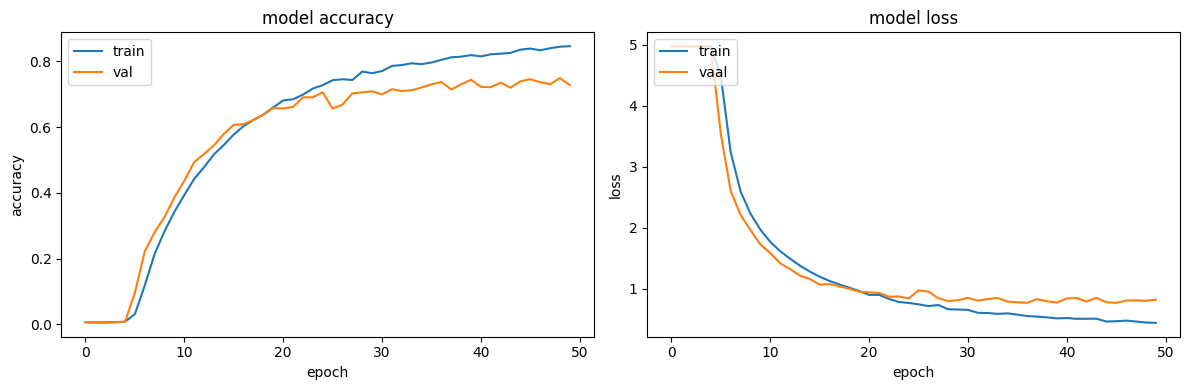

In [14]:
'''
Plot the performance related details from 144-class model
'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'vaal'], loc='upper left')

plt.tight_layout()
plt.show()

# Regression model

In [3]:
images = np.load("/kaggle/input/clock-dataset/images.npy") / 255
labels = np.load("/kaggle/input/clock-dataset/labels.npy")


# Transform labels into a single continuous value
time_values = labels[:, 0] + labels[:, 1] / 60.0
time_values = time_values.reshape(-1, 1)


# Prepare the train / validation / test data from dataset
X_train, X_var, y_train, y_var = train_test_split(images, time_values, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_var, y_var, test_size=0.5, random_state=42)

In [4]:
'''
CNN network for regression problem
'''

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=4, activation='leaky_relu', padding='same')

model = keras.Sequential([
    DefaultConv2D(filters=16, kernel_size=7, input_shape=[150, 150, 1], kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=32),
    layers.MaxPooling2D(pool_size=4),
    DefaultConv2D(filters=64),
    layers.MaxPooling2D(pool_size=4),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units=256, activation='leaky_relu'),
    layers.Dense(units=512, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='linear')  
])

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [5]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid))

# Evaluate the regression model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Regression model test MAE: {test_mae}')

Epoch 1/50


2023-11-04 00:29:33.839086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


338/338 [==============================] - 14s 14ms/step - loss: 12.9912 - mae: 3.0677 - val_loss: 12.1903 - val_mae: 2.9454
Epoch 2/50
338/338 [==============================] - 4s 10ms/step - loss: 10.8800 - mae: 2.7431 - val_loss: 9.6489 - val_mae: 2.5386
Epoch 3/50
338/338 [==============================] - 4s 10ms/step - loss: 9.0850 - mae: 2.4147 - val_loss: 7.5607 - val_mae: 2.1557
Epoch 4/50
338/338 [==============================] - 4s 11ms/step - loss: 7.9017 - mae: 2.2182 - val_loss: 6.9949 - val_mae: 2.0572
Epoch 5/50
338/338 [==============================] - 4s 11ms/step - loss: 7.0687 - mae: 2.0776 - val_loss: 6.4798 - val_mae: 1.9587
Epoch 6/50
338/338 [==============================] - 4s 10ms/step - loss: 6.0740 - mae: 1.8980 - val_loss: 5.5944 - val_mae: 1.7866
Epoch 7/50
338/338 [==============================] - 4s 10ms/step - loss: 5.3383 - mae: 1.7526 - val_loss: 5.2710 - val_mae: 1.7729
Epoch 8/50
338/338 [==============================] - 4s 10ms/step - loss: 4

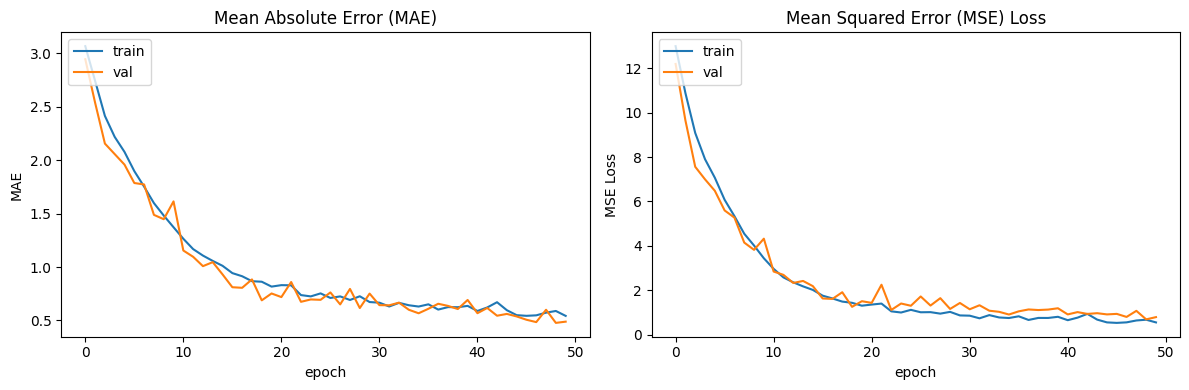

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set_title('Mean Absolute Error (MAE)')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Mean Squared Error (MSE) Loss')
ax2.set_ylabel('MSE Loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

# Multi-head models

In [2]:
images = np.load("/kaggle/input/clock-dataset/images.npy") / 255
labels = np.load("/kaggle/input/clock-dataset/labels.npy")


# Transform labels into hours and minutes
hours = labels[:, 0]
minutes = labels[:, 1] / 60.0
hours = hours.reshape(-1, 1)
minutes = minutes.reshape(-1, 1)

hours = to_categorical(hours, num_classes=12)


# Prepare the train / validation / test data from dataset
X_train, X_var, h_train, h_var, m_train, m_var = train_test_split(
    images, hours, minutes, test_size=0.4, random_state=42)
X_test, X_valid, h_test, h_valid, m_test, m_valid = train_test_split(
    X_var, h_var, m_var, test_size=0.5, random_state=42)

In [3]:
DefaultConv2D = partial(layers.Conv2D, kernel_size=4, activation='leaky_relu', padding='same')


class MultiHeadModel():
    def make_default_hidden_layers(self, inputs):
        x = DefaultConv2D(filters=16, kernel_size=7, kernel_initializer="he_normal")(inputs)
        x = layers.MaxPooling2D(pool_size=4)(x)
        x = DefaultConv2D(filters=32)(x)
        x = layers.MaxPooling2D(pool_size=4)(x)
        x = DefaultConv2D(filters=64)(x)
        x = layers.MaxPooling2D(pool_size=4)(x)
        x = layers.Dropout(0.3)(x)
        return x
    
    
    def build_hour_branch(self, inputs, num_categories):
        x = self.make_default_hidden_layers(inputs)
        x = layers.Flatten()(x)
        x = layers.Dense(units=256, activation='leaky_relu')(x)
        x = layers.Dense(units=512, activation='leaky_relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(units=num_categories, activation="softmax", name="hour_output")(x)
        return x
    
    
    def build_minute_branch(self, inputs):   
        x = self.make_default_hidden_layers(inputs)
        x = layers.Flatten()(x)
        x = layers.Dense(units=256, activation='leaky_relu')(x)
        x = layers.Dense(units=512, activation='leaky_relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(units=1, activation='linear', name="minute_output")(x)
        return x
    
    
    def assemble_full_model(self, width, height, num_categories):
        input_shape = (height, width, 1)
        inputs = layers.Input(shape=input_shape)
        hour_branch = self.build_hour_branch(inputs, num_categories)
        minute_branch = self.build_minute_branch(inputs)
        model = keras.Model(inputs=inputs, outputs = [hour_branch, minute_branch])
        return model

    
model = MultiHeadModel().assemble_full_model(150, 150, num_categories=12)
model.summary()


model.compile(optimizer='adam', 
              loss={
                  'hour_output': 'categorical_crossentropy', 
                  'minute_output': 'mean_squared_error'},
              metrics={
                  'hour_output': 'accuracy', 
                  'minute_output': 'mae'})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 16  800         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 150, 150, 16  800         ['input_1[0][0]']                
                                )                                                             

In [4]:
history = model.fit(X_train, {'hour_output': h_train, 'minute_output': m_train}, epochs=50, batch_size=32, 
                    validation_data=(X_valid, {'hour_output': h_valid, 'minute_output': m_valid}))

Epoch 1/50


2023-11-04 10:22:46.934081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


338/338 [==============================] - 17s 22ms/step - loss: 2.5880 - hour_output_loss: 2.4882 - minute_output_loss: 0.0998 - hour_output_accuracy: 0.0869 - minute_output_mae: 0.2615 - val_loss: 2.5743 - val_hour_output_loss: 2.4841 - val_minute_output_loss: 0.0902 - val_hour_output_accuracy: 0.0811 - val_minute_output_mae: 0.2556
Epoch 2/50
338/338 [==============================] - 6s 18ms/step - loss: 2.4414 - hour_output_loss: 2.3578 - minute_output_loss: 0.0836 - hour_output_accuracy: 0.1297 - minute_output_mae: 0.2480 - val_loss: 2.1313 - val_hour_output_loss: 2.0514 - val_minute_output_loss: 0.0799 - val_hour_output_accuracy: 0.2047 - val_minute_output_mae: 0.2417
Epoch 3/50
338/338 [==============================] - 6s 18ms/step - loss: 1.9259 - hour_output_loss: 1.8489 - minute_output_loss: 0.0770 - hour_output_accuracy: 0.2689 - minute_output_mae: 0.2309 - val_loss: 1.5617 - val_hour_output_loss: 1.4918 - val_minute_output_loss: 0.0699 - val_hour_output_accuracy: 0.3733 -

In [7]:
test_loss, test_hour_loss, test_minute_loss, test_hour_accuracy, test_minute_mae  = model.evaluate(X_test, {'hour_output': h_test, 'minute_output': m_test})
print(f'Muti-head model test predictions, hour_accuracy: {test_hour_accuracy}, minute_mae: {test_minute_mae}')

113/113 [==============================] - 1s 7ms/step - loss: 0.2708 - hour_output_loss: 0.2533 - minute_output_loss: 0.0176 - hour_output_accuracy: 0.9119 - minute_output_mae: 0.0677
Muti-head model test predictions, hour_accuracy: 0.9119444489479065, minute_mae: 0.0677344799041748


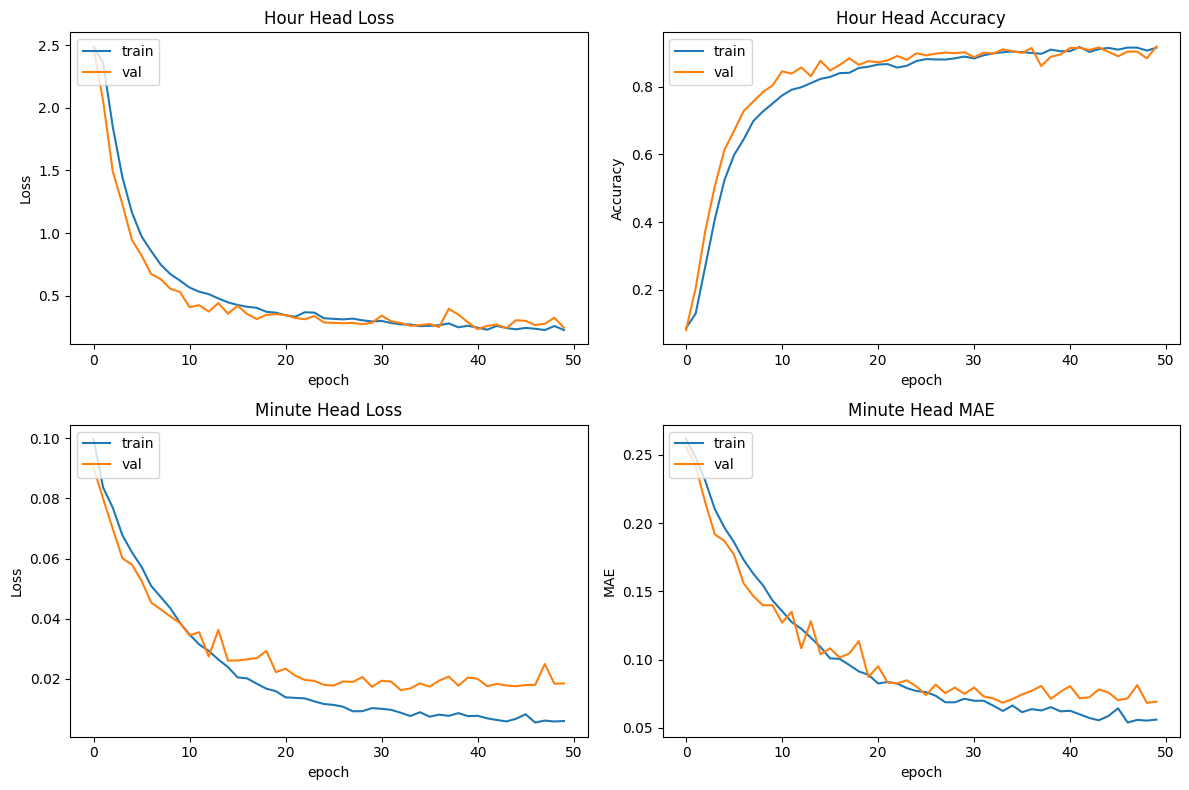

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(history.history['hour_output_loss'])
axes[0, 0].plot(history.history['val_hour_output_loss'])
axes[0, 0].set_title('Hour Head Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].legend(['train', 'val'], loc='upper left')

axes[0, 1].plot(history.history['hour_output_accuracy'])
axes[0, 1].plot(history.history['val_hour_output_accuracy'])
axes[0, 1].set_title('Hour Head Accuracy')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].legend(['train', 'val'], loc='upper left')

axes[1, 0].plot(history.history['minute_output_loss'])
axes[1, 0].plot(history.history['val_minute_output_loss'])
axes[1, 0].set_title('Minute Head Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].legend(['train', 'val'], loc='upper left')

axes[1, 1].plot(history.history['minute_output_mae'])
axes[1, 1].plot(history.history['val_minute_output_mae'])
axes[1, 1].set_title('Minute Head MAE')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()